In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import itertools
nltk.download('vader_lexicon')


from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
#!pip install swifter

***Importing Dataset***

In [3]:
data = pd.read_csv("/content/feedback.csv")
data

,Unnamed: 0,Compliment
0,NaN,Compliment
1,NaN,Compliment
2,NaN,Compliment
3,NaN,Compliment
4,NaN,Compliment
...,...,...
2960,As feedback I thought the thee sessions were t...,Compliment
2961,Can I also say in general that I have found th...,Compliment
2962,As I said on the call earlier – you have reall...,Compliment
2963,Your guidelines do not appear to indicate whet...,Grumble


In [4]:
df = data.rename(columns={'Unnamed: 0': 'feedback', 'Compliment': 'feedtype'}).dropna()
df

,feedback,feedtype
13,It was easy but I think the Form can be improv...,Neutral
18,Shorten registration times. It's automatic ove...,Grumble
20,BECAUSE A LOT OF THE INFORMATION BEING REQUEST...,Grumble
21,Why does it take 10 days to approve a registra...,Neutral
22,The website is easy to use however the turnaro...,Neutral
...,...,...
2960,As feedback I thought the thee sessions were t...,Compliment
2961,Can I also say in general that I have found th...,Compliment
2962,As I said on the call earlier – you have reall...,Compliment
2963,Your guidelines do not appear to indicate whet...,Grumble


In [5]:
feedback= df['feedtype']
pos_feed =0
neg_feed=0
neutral=0

for f in feedback:
  if f=='Compliment':
    pos_feed+=1
  elif f=='Grumble':
    neg_feed+=1
  elif f=='Neutral':
    neutral+=1
print(pos_feed)
print(neg_feed)
print(neutral)

739
409
363


***Removing Punctuation***

In [6]:
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['feedback']= df['feedback'].apply(lambda x:remove_punctuation(x))
df.head()

,feedback,feedtype
13,It was easy but I think the Form can be improv...,Neutral
18,Shorten registration times Its automatic over ...,Grumble
20,BECAUSE A LOT OF THE INFORMATION BEING REQUEST...,Grumble
21,Why does it take 10 days to approve a registra...,Neutral
22,The website is easy to use however the turnaro...,Neutral


In [7]:
df['feedback'] = df['feedback'].str.lower()
df['feedtype'] = df['feedtype'].str.lower()

Text(0, 0.5, '')

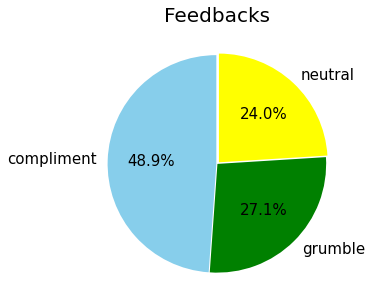

In [8]:
feed_df = df["feedtype"]
plt.figure(figsize=(5,5))
feed_df.value_counts().plot(kind="pie", autopct="%1.1f%%", textprops={"fontsize": 15}, startangle=90, explode=(0.01, 0,0.02), colors=["skyblue","green","yellow"])
plt.title("Feedbacks", fontsize=20)
plt.ylabel("")

In [9]:
import seaborn as sns

[Text(0, 0, '739'), Text(0, 0, '410'), Text(0, 0, '363')]

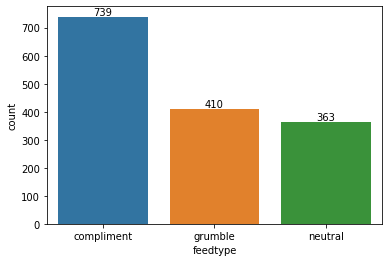

In [10]:
bar_plot = sns.countplot(x=df['feedtype'],order=df['feedtype'].value_counts(ascending=False).index);
values = df['feedtype'].value_counts(ascending=False).values
bar_plot.bar_label(container=bar_plot.containers[0], labels=values)

In [11]:
df

,feedback,feedtype
13,it was easy but i think the form can be improv...,neutral
18,shorten registration times its automatic over ...,grumble
20,because a lot of the information being request...,grumble
21,why does it take 10 days to approve a registra...,neutral
22,the website is easy to use however the turnaro...,neutral
...,...,...
2960,as feedback i thought the thee sessions were t...,compliment
2961,can i also say in general that i have found th...,compliment
2962,as i said on the call earlier – you have reall...,compliment
2963,your guidelines do not appear to indicate whet...,grumble


In [12]:
df['len_feedback'] = df['feedback'].apply(len)

In [13]:
df

,feedback,feedtype,len_feedback
13,it was easy but i think the form can be improv...,neutral,154
18,shorten registration times its automatic over ...,grumble,56
20,because a lot of the information being request...,grumble,63
21,why does it take 10 days to approve a registra...,neutral,50
22,the website is easy to use however the turnaro...,neutral,77
...,...,...,...
2960,as feedback i thought the thee sessions were t...,compliment,82
2961,can i also say in general that i have found th...,compliment,140
2962,as i said on the call earlier – you have reall...,compliment,205
2963,your guidelines do not appear to indicate whet...,grumble,441


In [14]:
grouped = df.groupby('feedtype')['len_feedback'].agg([len, 'mean', 'max','min'])
grouped

,len,mean,max,min
feedtype,,,,
compliment,739,45.253045,539,0
grumble,410,143.043902,894,5
neutral,363,132.022039,871,6


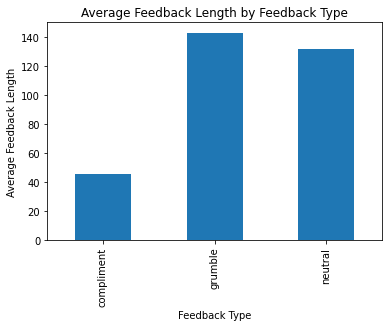

In [15]:
# group the data by feedback type and calculate average feedback length
grouped_df = df.groupby(['feedtype'])['len_feedback'].mean()

# create a bar plot
grouped_df.plot(kind='bar')
plt.title('Average Feedback Length by Feedback Type')
plt.xlabel('Feedback Type')
plt.ylabel('Average Feedback Length')
plt.show()


<Axes: xlabel='feedtype', ylabel='len_feedback'>

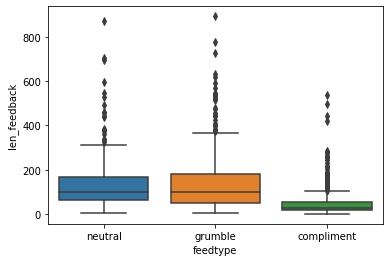

In [16]:
sns.boxplot(x='feedtype', y='len_feedback', data=df)

In [17]:
# Calculate the frequency of each feedback length
freq = df['len_feedback'].value_counts()

# Print the frequency table
print(freq)

22     29
7      27
14     27
19     26
23     23
       ..
633     1
302     1
456     1
198     1
340     1
Name: len_feedback, Length: 320, dtype: int64


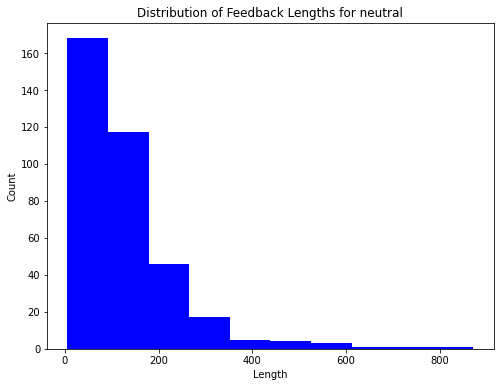

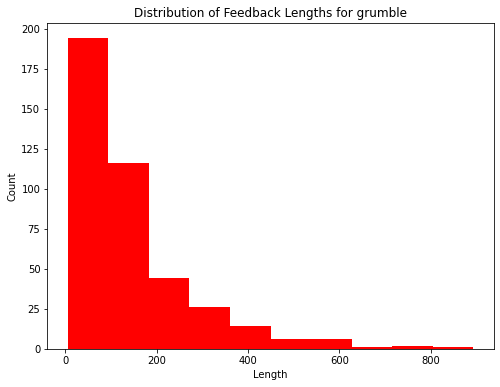

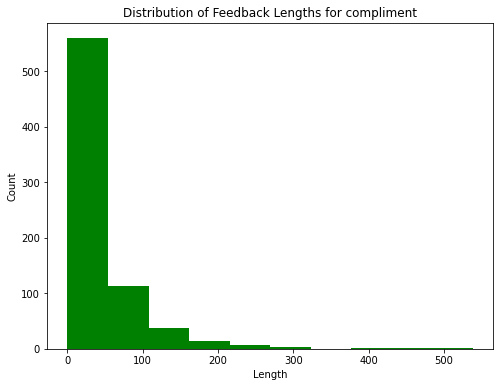

In [18]:
# Define a dictionary of colors for each feedback type
colors = {'compliment': 'green', 'grumble': 'red', 'neutral': 'blue'}

# Create separate histograms for the distribution of feedback lengths for each type
for feedback_type in df['feedtype'].unique():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(df[df['feedtype']==feedback_type]['len_feedback'], color=colors[feedback_type])
    ax.set_title('Distribution of Feedback Lengths for {}'.format(feedback_type))
    ax.set_xlabel('Length')
    ax.set_ylabel('Count')
    plt.show()

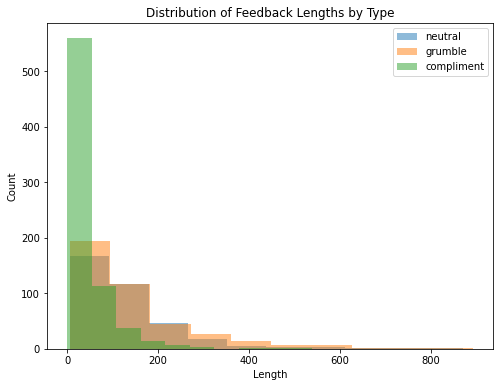

In [19]:
# Create histograms for the distribution of feedback lengths for each type
fig, ax = plt.subplots(figsize=(8, 6))

for feedback_type in df['feedtype'].unique():
    ax.hist(df[df['feedtype']==feedback_type]['len_feedback'], alpha=0.5, label=feedback_type)

ax.set_title('Distribution of Feedback Lengths by Type')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
ax.legend()

plt.show()


In [20]:
df[df['len_feedback']==894]['feedback'].iloc[0]

'my solicitor did all the forms when my partner and i bought our new home together we sold both our properties to buy our joint property carols house sold first i then put mine on the market my share of the new house was paid in cash from monies left to me by my mother my house was empty for many months\n i was not happy my solicitor left me to claim the refund i had to go back to her for the tr1 forms as you requested i then had to go back to her for the refund figure\n i felt totally lost as i had to complete this form i had 2 properties temporarily as 1 was in the process of being up for sale no home was a 2nd or holiday home\n the solicitor should be obliged to do the paperwork when my house sold and gave me the £4125 back then i am not happy at this process i am not a solicitor and we are talking tax to the welsh government i wanted to get it right my solicitor should have done it'

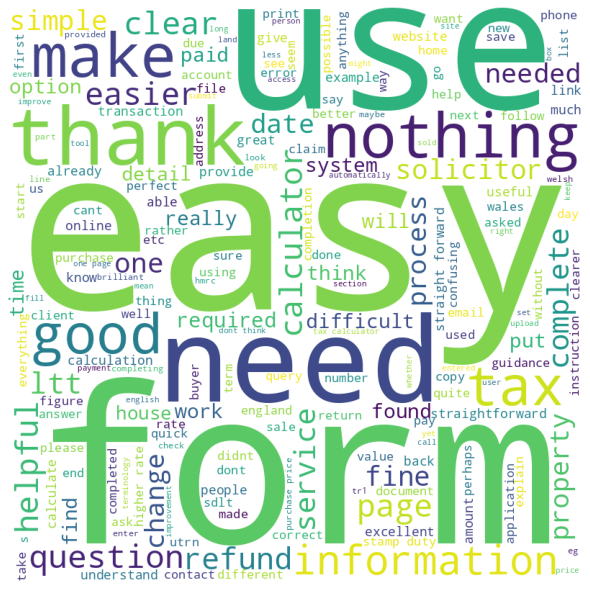

In [21]:
# Join all feedback strings into a single text variable
text = ' '.join(df['feedback'].values)

# Create the word cloud with the WordCloud library
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 

# Plot the word cloud using matplotlib
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# Display the word cloud
plt.show()

In [22]:
df_new = df[df['len_feedback']>100]

In [23]:
df_new

,feedback,feedtype,len_feedback
13,it was easy but i think the form can be improv...,neutral,154
37,our organisation has an account but i cannot a...,grumble,169
38,can you please provide a tick box for a second...,compliment,110
41,make the instructions clearer and the link to ...,grumble,121
78,i hope there is no time limit on submitting lt...,grumble,204
...,...,...,...
2958,just wanted to say i joined in all 3 webinars ...,compliment,186
2959,the diagrams are not clear in showing the rule...,grumble,340
2961,can i also say in general that i have found th...,compliment,140
2962,as i said on the call earlier – you have reall...,compliment,205


[Text(0, 0, '205'), Text(0, 0, '178'), Text(0, 0, '71')]

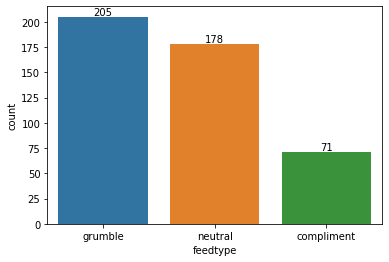

In [24]:
bar_plot = sns.countplot(x=df_new['feedtype'],order=df_new['feedtype'].value_counts(ascending=False).index);
values = df_new['feedtype'].value_counts(ascending=False).values
bar_plot.bar_label(container=bar_plot.containers[0], labels=values)

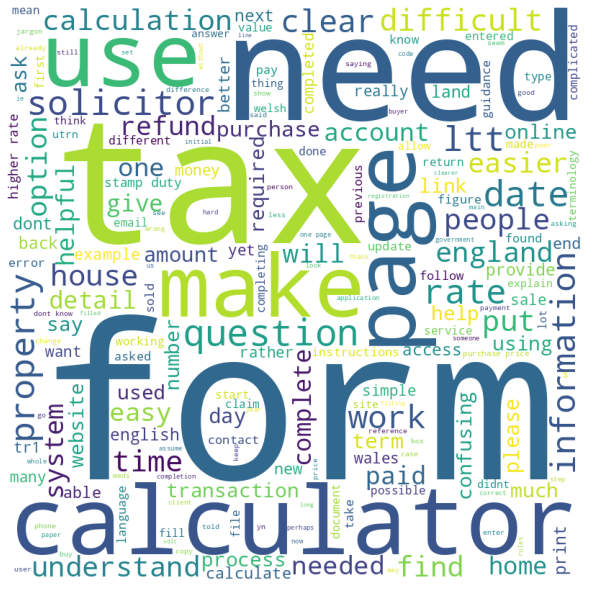

In [25]:
grumble_feedback = df[df['feedtype'] == 'grumble']['feedback'].tolist()

grumble_text = ' '.join(grumble_feedback)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(grumble_text)

# Display the generated image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [26]:
keywords = ['tax', 'calculator', 'form', 'LTT']


filtered_feedback = df_new[df_new['feedback'].str.contains('|'.join(keywords))]

In [27]:
filtered_feedback

,feedback,feedtype,len_feedback
13,it was easy but i think the form can be improv...,neutral,154
78,i hope there is no time limit on submitting lt...,grumble,204
100,the information leading you where you need to ...,grumble,142
129,each time the postcode was inserted and it ask...,grumble,311
191,improve the system using the verification code...,grumble,122
...,...,...,...
2944,i was hoping your survey at the end might offe...,compliment,278
2945,i found the webinars very useful and informati...,compliment,127
2947,in terms of new user setup the only improvemen...,neutral,595
2951,i recently attended the chester and north wale...,compliment,188


[Text(0, 0, '100'), Text(0, 0, '93'), Text(0, 0, '27')]

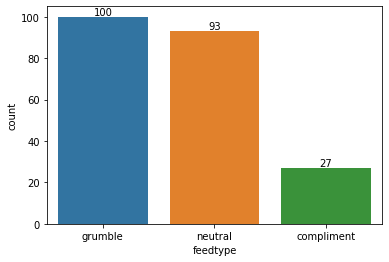

In [28]:
bar_plot = sns.countplot(x=filtered_feedback['feedtype'],order=filtered_feedback['feedtype'].value_counts(ascending=False).index);
values = filtered_feedback['feedtype'].value_counts(ascending=False).values
bar_plot.bar_label(container=bar_plot.containers[0], labels=values)

In [29]:
filtered_feedback[filtered_feedback['feedtype']=='neutral']

,feedback,feedtype,len_feedback
13,it was easy but i think the form can be improv...,neutral,154
215,it was good however this is a very urgent appl...,neutral,262
287,having calculated the tax for one house value ...,neutral,119
475,have more defined boxes of where you need to f...,neutral,156
534,make it clear that if a transaction is for a s...,neutral,159
...,...,...,...
2805,would prefer a copy of the completed form to b...,neutral,113
2877,in ltta2440 contingent uncertain or unascertai...,neutral,528
2880,i noticed that ltta2040 linked transactions ha...,neutral,871
2929,really helpful id done the return myself form...,neutral,224


***Building word cloud***

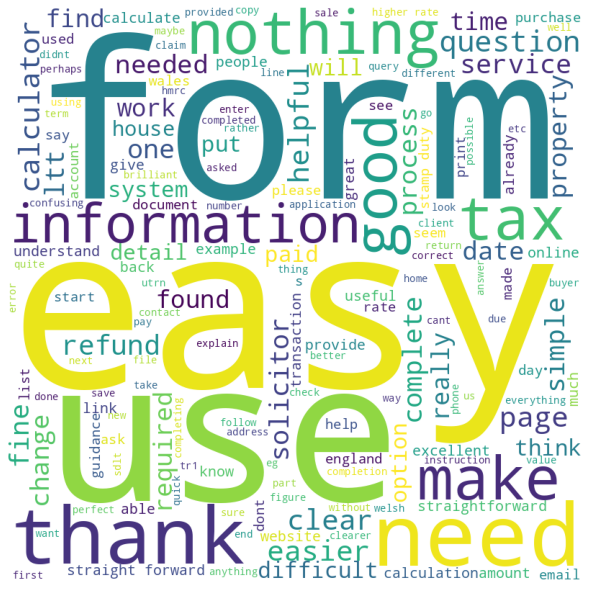

In [30]:
comment_words = ''
stopwords = set(STOPWORDS)
for val in df.feedback:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

***Data Cleaning***

In [31]:
import re

In [32]:
def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string 

In [33]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [34]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string 

In [35]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [36]:
import swifter

df['feedback'] = df['feedback'].swifter.apply(remove_urls)
df['feedback'] = df['feedback'].swifter.apply(deEmojify)
df['feedback'] = df['feedback'].swifter.apply(remove_symbols)
df['feedback'] = df['feedback'].swifter.apply(unify_whitespaces)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [37]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sp = spacy.load('en_core_web_sm')

StopWords = sp.Defaults.stop_words
StopWords = [x.lower() for x in StopWords]
StopWords.extend(list(stopwords.words('english')))
StopWords = list(set(StopWords))

def remove_stopwords(x):
    
    words = []
    my_list = x
    
    tokenized_my_list = word_tokenize(my_list) 
    words = [w for w in tokenized_my_list if not w in StopWords]
        
    return " ".join(words)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [38]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
df['feedback'] = df['feedback'].apply(lambda x:remove_stopwords(x))

In [40]:
df

,feedback,feedtype,len_feedback
13,easy think form improved adding tick box buyer...,neutral,154
18,shorten registration times automatic bridge,grumble,56
20,lot information requested repetitive,grumble,63
21,10 days approve registration,neutral,50
22,website easy use turnaround time long,neutral,77
...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82
2961,general found wra helpful dealing technical qu...,compliment,140
2962,said earlier helpful patient pass feedback lin...,compliment,205
2963,guidelines appear indicate 40000 exemption app...,grumble,441


In [41]:
def tokenization(text):
  tokens = re.findall("[\w]+",text)
  return tokens
#apply tokens
df['clean_feedback'] = df['feedback'].apply(lambda x:tokenization(x))

In [42]:
df['clean_feedback']

13      [easy, think, form, improved, adding, tick, bo...
18      [shorten, registration, times, automatic, bridge]
20              [lot, information, requested, repetitive]
21                      [10, days, approve, registration]
22           [website, easy, use, turnaround, time, long]
                              ...                        
2960    [feedback, thought, thee, sessions, right, len...
2961    [general, found, wra, helpful, dealing, techni...
2962    [said, earlier, helpful, patient, pass, feedba...
2963    [guidelines, appear, indicate, 40000, exemptio...
2964                            [hope, says, great, miss]
Name: clean_feedback, Length: 1512, dtype: object

***Analysis after cleaning***

In [43]:
compliment_reviews =df[df['feedtype']=='compliment']['clean_feedback']
compliment_reviews_words = list(itertools.chain(*compliment_reviews))

neutral_reviews =df[df['feedtype']=='neutral']['clean_feedback']
neutral_reviews_words = list(itertools.chain(*neutral_reviews))

grumble_reviews =df[df['feedtype']=='grumble']['clean_feedback']
grumble_reviews_words = list(itertools.chain(*grumble_reviews))

In [44]:
from nltk import collections
compliment_word_freq = collections.Counter(compliment_reviews_words)
neutral_word_freq = collections.Counter(neutral_reviews_words)
grumble_word_freq = collections.Counter(grumble_reviews_words)

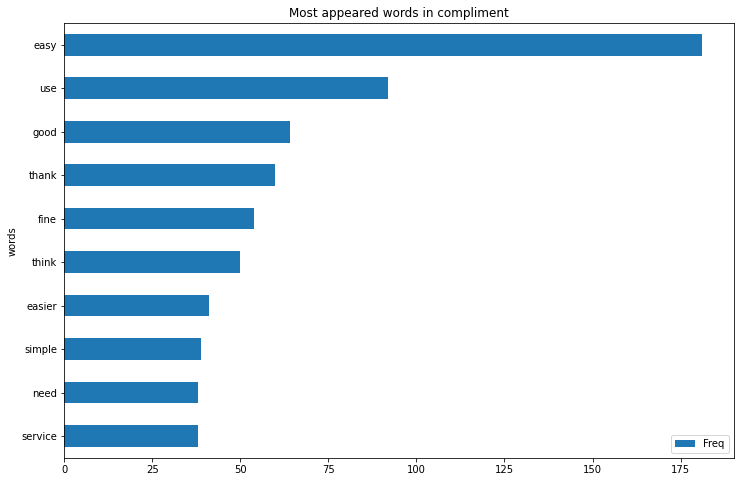

In [45]:
compliment_word_freq_df = pd.DataFrame(compliment_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
compliment_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax,)
plt.title("Most appeared words in compliment")
plt.show()

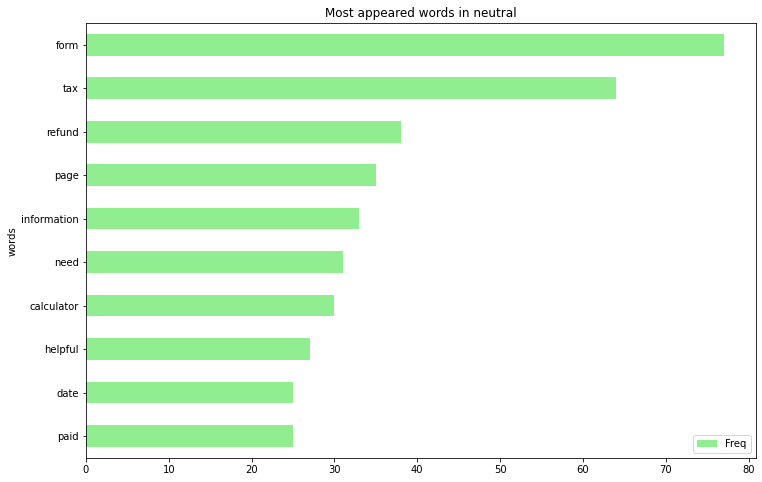

In [46]:
neutral_word_freq_df = pd.DataFrame(neutral_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
neutral_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax , color = 'lightgreen')
plt.title("Most appeared words in neutral")
plt.show()

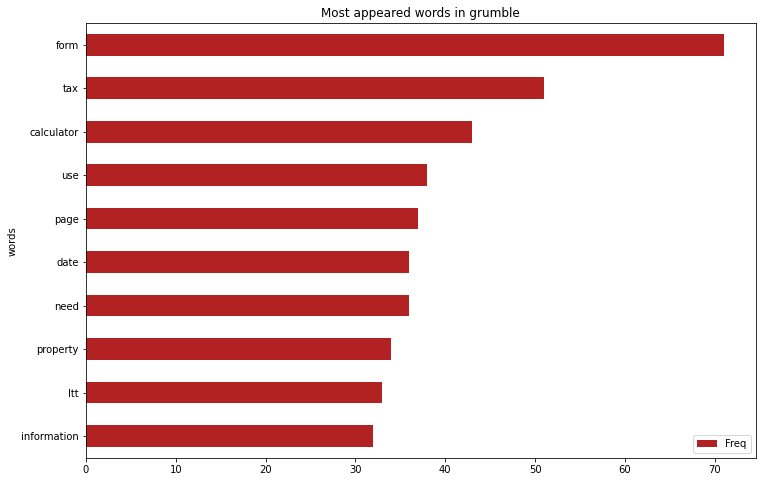

In [47]:
grumble_word_freq_df = pd.DataFrame(grumble_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
grumble_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax, color = 'Firebrick')
plt.title("Most appeared words in grumble")
plt.show()

***Creating n-grams***

In [48]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('-'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

In [49]:
df["bigram_text"] = df["feedback"].swifter.apply(get_ngrams, n=2)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [50]:
df

,feedback,feedtype,len_feedback,clean_feedback,bigram_text
13,easy think form improved adding tick box buyer...,neutral,154,"[easy, think, form, improved, adding, tick, bo...",easy-think think-form form-improved improved-a...
18,shorten registration times automatic bridge,grumble,56,"[shorten, registration, times, automatic, bridge]",shorten-registration registration-times times-...
20,lot information requested repetitive,grumble,63,"[lot, information, requested, repetitive]",lot-information information-requested requeste...
21,10 days approve registration,neutral,50,"[10, days, approve, registration]",10-days days-approve approve-registration
22,website easy use turnaround time long,neutral,77,"[website, easy, use, turnaround, time, long]",website-easy easy-use use-turnaround turnaroun...
...,...,...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82,"[feedback, thought, thee, sessions, right, len...",feedback-thought thought-thee thee-sessions se...
2961,general found wra helpful dealing technical qu...,compliment,140,"[general, found, wra, helpful, dealing, techni...",general-found found-wra wra-helpful helpful-de...
2962,said earlier helpful patient pass feedback lin...,compliment,205,"[said, earlier, helpful, patient, pass, feedba...",said-earlier earlier-helpful helpful-patient p...
2963,guidelines appear indicate 40000 exemption app...,grumble,441,"[guidelines, appear, indicate, 40000, exemptio...",guidelines-appear appear-indicate indicate-400...


In [51]:
df["bigram_text"]

13      easy-think think-form form-improved improved-a...
18      shorten-registration registration-times times-...
20      lot-information information-requested requeste...
21              10-days days-approve approve-registration
22      website-easy easy-use use-turnaround turnaroun...
                              ...                        
2960    feedback-thought thought-thee thee-sessions se...
2961    general-found found-wra wra-helpful helpful-de...
2962    said-earlier earlier-helpful helpful-patient p...
2963    guidelines-appear appear-indicate indicate-400...
2964                      hope-says says-great great-miss
Name: bigram_text, Length: 1512, dtype: object

In [52]:
df["trigram_text"] = df["feedback"].swifter.apply(get_ngrams, n=3)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [53]:
df['trigram_text']

13      easy-think-form think-form-improved form-impro...
18      shorten-registration-times registration-times-...
20      lot-information-requested information-requeste...
21              10-days-approve days-approve-registration
22      website-easy-use easy-use-turnaround use-turna...
                              ...                        
2960    feedback-thought-thee thought-thee-sessions th...
2961    general-found-wra found-wra-helpful wra-helpfu...
2962    said-earlier-helpful earlier-helpful-patient h...
2963    guidelines-appear-indicate appear-indicate-400...
2964                      hope-says-great says-great-miss
Name: trigram_text, Length: 1512, dtype: object

In [54]:
bigram_str_list = df['bigram_text'].tolist()
bigram_str = ' '.join(bigram_str_list)

In [55]:
import re
from operator import itemgetter


item1 = itemgetter(1)

def wordfreq(text):
    d = {}
    for word in re.findall(r"\S+", text):
        if word.isdigit():
            continue

        word_lower = word.lower()

       
        if word_lower in d:
            d2 = d[word_lower]
        else:
            d2 = {}
            d[word_lower] = d2

        
        d2[word] = d2.get(word, 0) + 1

    d3 = {}
    for d2 in d.values():
        first = max(d2.items(), key=item1)[0]
        d3[first] = sum(d2.values())

    return d3.items()

freqs1 = wordfreq(bigram_str)

***Creating word cloud for bigrams and trigrams***

In [56]:
type(freqs1)
l = dict(freqs1)
l = dict(sorted(l.items(), key=lambda item: item[1], reverse=True))

In [57]:
l

{'easy-use': 70,
 'straight-forward': 39,
 'stamp-duty': 27,
 'higher-rate': 19,
 'tax-calculator': 17,
 'purchase-price': 16,
 'dont-think': 16,
 'dont-know': 13,
 'complete-form': 11,
 'quick-easy': 11,
 'simple-use': 11,
 'land-tax': 10,
 'tax-rates': 10,
 'easy-complete': 10,
 'main-residence': 10,
 'list-information': 9,
 'information-required': 9,
 'easy-follow': 8,
 'found-easy': 8,
 'second-home': 8,
 'think-easier': 8,
 'tr1-form': 8,
 'filling-form': 8,
 'completing-form': 8,
 'user-friendly': 7,
 'questions-page': 7,
 'land-transaction': 7,
 'easier-find': 7,
 'higher-rates': 7,
 'like-able': 7,
 'information-need': 7,
 'difficult-find': 7,
 'need-able': 7,
 'completion-statement': 7,
 'good-service': 7,
 'tax-paid': 7,
 'extremely-helpful': 6,
 'phone-number': 6,
 'land-registry': 6,
 'welsh-government': 6,
 'straightforward-use': 6,
 'use-thank': 6,
 'plain-english': 6,
 'duty-holiday': 6,
 'cant-think': 6,
 'service-easy': 6,
 'form-easy': 6,
 'need-easy': 6,
 'self-expla

In [58]:
word_cloud1 = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, 
                      collocations=False, normalize_plurals=False).generate_from_frequencies(l)


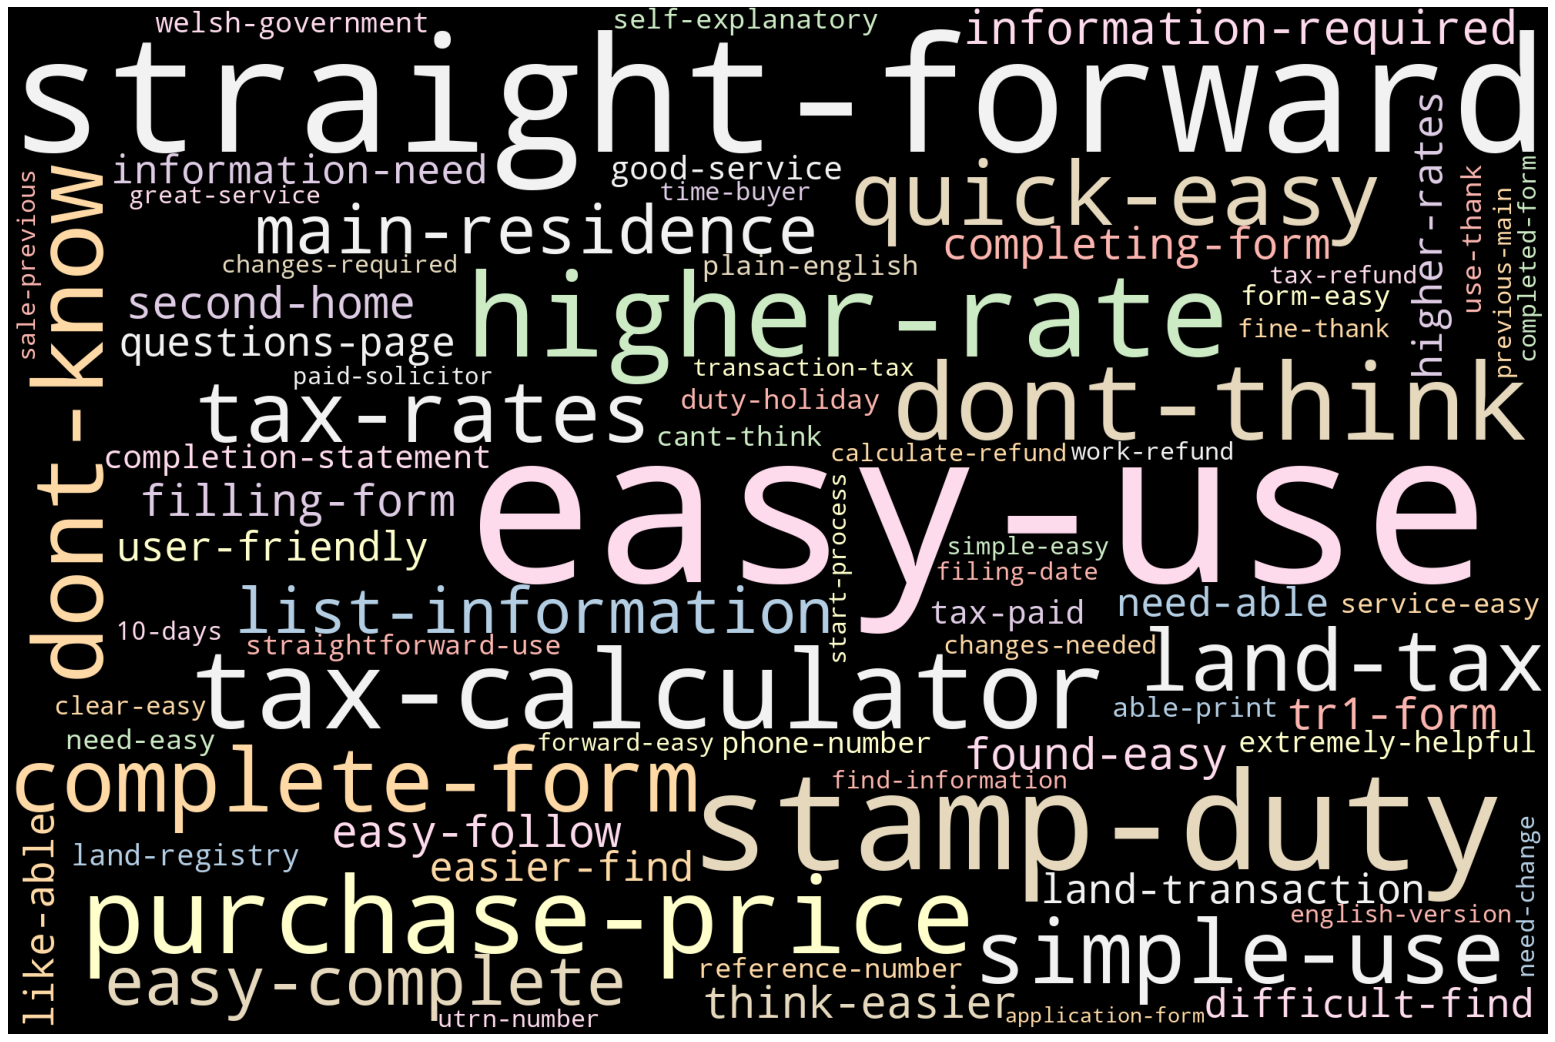

In [59]:
from matplotlib.pyplot import figure
def plot_cloud(word_cloud1):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(word_cloud1)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
plot_cloud(word_cloud1)

In [60]:
trigram_str_list = df['trigram_text'].tolist()
trigram_str = ' '.join(trigram_str_list)

In [61]:
freqs2 = wordfreq(trigram_str)
type(freqs2)
l1 = dict(freqs2)
l1 = dict(sorted(l1.items(), key=lambda item: item[1], reverse=True))
l1

{'easy-use-thank': 6,
 'stamp-duty-holiday': 6,
 'list-information-need': 5,
 'land-transaction-tax': 5,
 'previous-main-residence': 5,
 'straight-forward-easy': 5,
 'straightforward-easy-use': 4,
 'dont-think-easier': 4,
 'property-purchase-price': 3,
 'found-easy-use': 3,
 'easy-use-dont': 3,
 'set-date-field': 3,
 'date-field-numbers': 3,
 'field-numbers-phone': 3,
 'calculator-easy-use': 3,
 'effective-date-future': 3,
 'date-future-date': 3,
 'future-date-tax': 3,
 'date-tax-rates': 3,
 'tax-rates-alter': 3,
 'rates-alter-total': 3,
 'alter-total-tax': 3,
 'total-tax-different': 3,
 'tax-different-result': 3,
 'different-result-useful': 3,
 'result-useful-newbuild': 3,
 'useful-newbuild-home': 3,
 'newbuild-home-late': 3,
 'home-late-completion': 3,
 'dros-yr-wythnosau': 3,
 'yr-wythnosau-diwethaf': 3,
 'simple-straight-forward': 3,
 'easy-straight-forward': 3,
 'straight-forward-use': 3,
 'refund-calculated-automatically': 3,
 'list-information-required': 3,
 'required-start-proc

In [62]:
word_cloud2 = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, 
                      collocations=False, normalize_plurals=False).generate_from_frequencies(l1) 

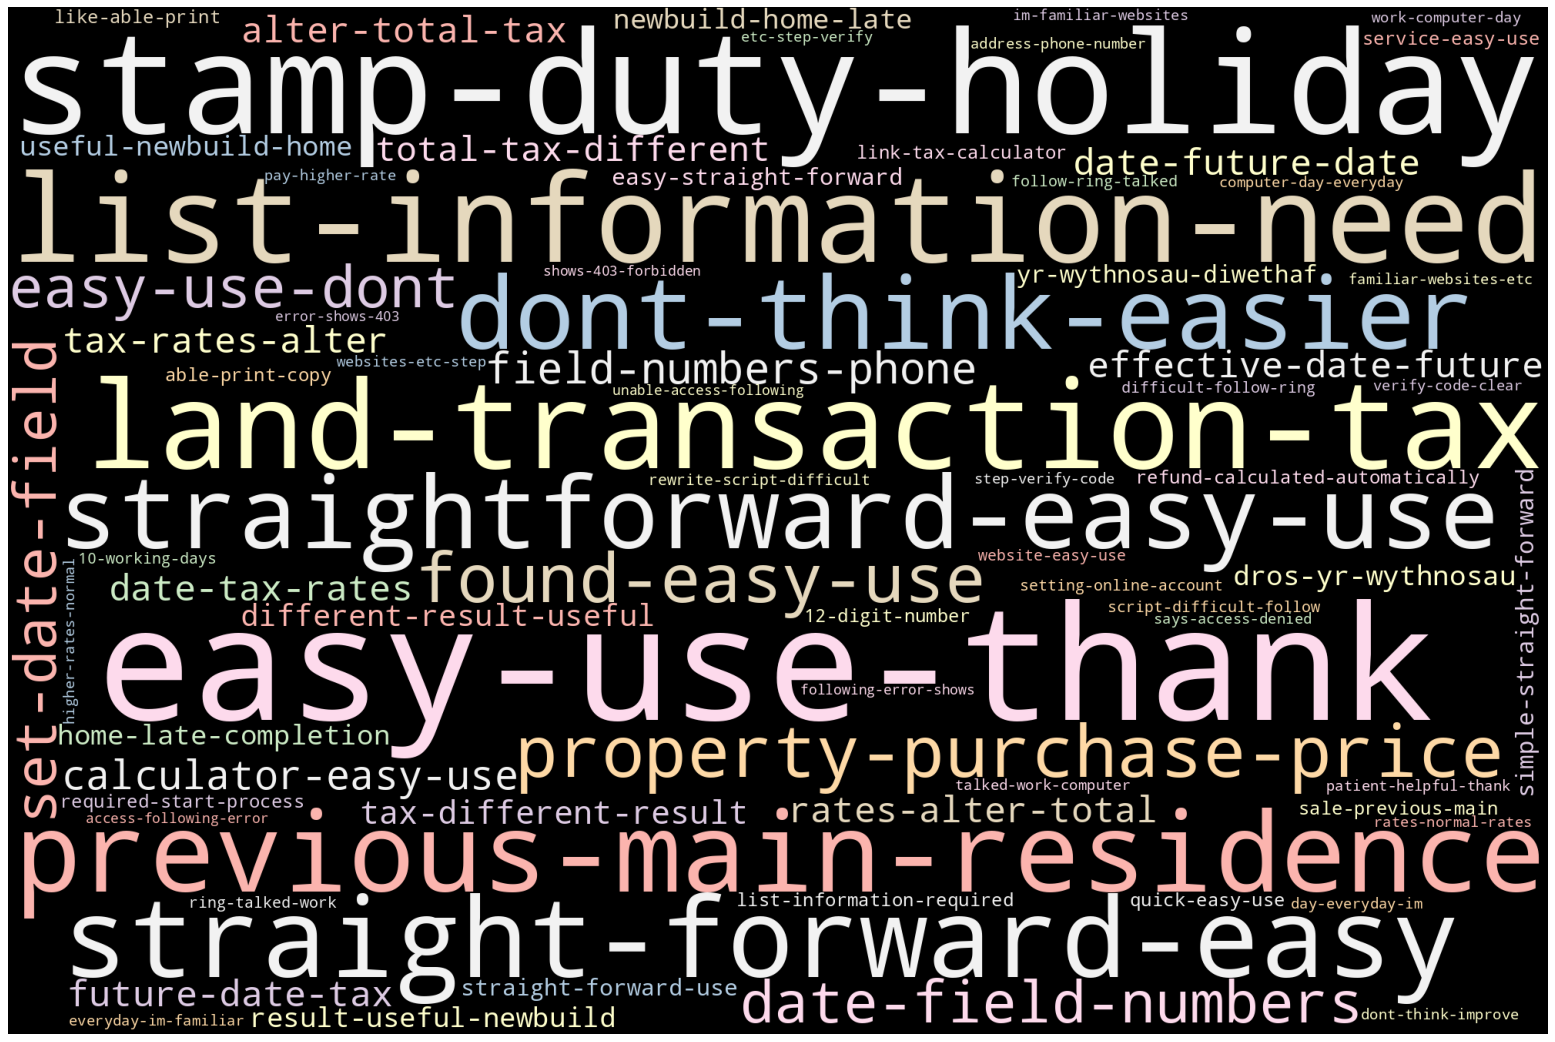

In [63]:
plot_cloud(word_cloud2)

In [64]:
df

,feedback,feedtype,len_feedback,clean_feedback,bigram_text,trigram_text
13,easy think form improved adding tick box buyer...,neutral,154,"[easy, think, form, improved, adding, tick, bo...",easy-think think-form form-improved improved-a...,easy-think-form think-form-improved form-impro...
18,shorten registration times automatic bridge,grumble,56,"[shorten, registration, times, automatic, bridge]",shorten-registration registration-times times-...,shorten-registration-times registration-times-...
20,lot information requested repetitive,grumble,63,"[lot, information, requested, repetitive]",lot-information information-requested requeste...,lot-information-requested information-requeste...
21,10 days approve registration,neutral,50,"[10, days, approve, registration]",10-days days-approve approve-registration,10-days-approve days-approve-registration
22,website easy use turnaround time long,neutral,77,"[website, easy, use, turnaround, time, long]",website-easy easy-use use-turnaround turnaroun...,website-easy-use easy-use-turnaround use-turna...
...,...,...,...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82,"[feedback, thought, thee, sessions, right, len...",feedback-thought thought-thee thee-sessions se...,feedback-thought-thee thought-thee-sessions th...
2961,general found wra helpful dealing technical qu...,compliment,140,"[general, found, wra, helpful, dealing, techni...",general-found found-wra wra-helpful helpful-de...,general-found-wra found-wra-helpful wra-helpfu...
2962,said earlier helpful patient pass feedback lin...,compliment,205,"[said, earlier, helpful, patient, pass, feedba...",said-earlier earlier-helpful helpful-patient p...,said-earlier-helpful earlier-helpful-patient h...
2963,guidelines appear indicate 40000 exemption app...,grumble,441,"[guidelines, appear, indicate, 40000, exemptio...",guidelines-appear appear-indicate indicate-400...,guidelines-appear-indicate appear-indicate-400...


***Copying n-grams into new dataframe***

In [65]:
new_df = df[['bigram_text','trigram_text','len_feedback']].copy()

In [66]:
df = df.drop(['bigram_text','trigram_text','len_feedback'], axis=1)

In [67]:
df

,feedback,feedtype,clean_feedback
13,easy think form improved adding tick box buyer...,neutral,"[easy, think, form, improved, adding, tick, bo..."
18,shorten registration times automatic bridge,grumble,"[shorten, registration, times, automatic, bridge]"
20,lot information requested repetitive,grumble,"[lot, information, requested, repetitive]"
21,10 days approve registration,neutral,"[10, days, approve, registration]"
22,website easy use turnaround time long,neutral,"[website, easy, use, turnaround, time, long]"
...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,"[feedback, thought, thee, sessions, right, len..."
2961,general found wra helpful dealing technical qu...,compliment,"[general, found, wra, helpful, dealing, techni..."
2962,said earlier helpful patient pass feedback lin...,compliment,"[said, earlier, helpful, patient, pass, feedba..."
2963,guidelines appear indicate 40000 exemption app...,grumble,"[guidelines, appear, indicate, 40000, exemptio..."


***Overall View***

In [68]:
df['feedtype'] = df['feedtype'].replace(['compliment','grumble','neutral'],[1,0,2])

In [69]:
df

,feedback,feedtype,clean_feedback
13,easy think form improved adding tick box buyer...,2,"[easy, think, form, improved, adding, tick, bo..."
18,shorten registration times automatic bridge,0,"[shorten, registration, times, automatic, bridge]"
20,lot information requested repetitive,0,"[lot, information, requested, repetitive]"
21,10 days approve registration,2,"[10, days, approve, registration]"
22,website easy use turnaround time long,2,"[website, easy, use, turnaround, time, long]"
...,...,...,...
2960,feedback thought thee sessions right length in...,1,"[feedback, thought, thee, sessions, right, len..."
2961,general found wra helpful dealing technical qu...,1,"[general, found, wra, helpful, dealing, techni..."
2962,said earlier helpful patient pass feedback lin...,1,"[said, earlier, helpful, patient, pass, feedba..."
2963,guidelines appear indicate 40000 exemption app...,0,"[guidelines, appear, indicate, 40000, exemptio..."


In [70]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    txt = BeautifulSoup(raw_text, 'lxml').get_text()
    letter_only = re.sub("[^a-zA-Z]", " ", txt) 
    words = letter_only.lower().split()  
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    if stemming==True:
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:
        return (words)
    
    return( " ".join(words))

In [71]:
df['cleaned_feedback'] = df['feedback'].apply(cleanText, remove_stopwords=True, stemming=True, split_text=True)

In [72]:
df

,feedback,feedtype,clean_feedback,cleaned_feedback
13,easy think form improved adding tick box buyer...,2,"[easy, think, form, improved, adding, tick, bo...","[easi, think, form, improv, ad, tick, box, buy..."
18,shorten registration times automatic bridge,0,"[shorten, registration, times, automatic, bridge]","[shorten, registr, time, automat, bridg]"
20,lot information requested repetitive,0,"[lot, information, requested, repetitive]","[lot, inform, request, repetit]"
21,10 days approve registration,2,"[10, days, approve, registration]","[day, approv, registr]"
22,website easy use turnaround time long,2,"[website, easy, use, turnaround, time, long]","[websit, easi, use, turnaround, time, long]"
...,...,...,...,...
2960,feedback thought thee sessions right length in...,1,"[feedback, thought, thee, sessions, right, len...","[feedback, thought, thee, session, right, leng..."
2961,general found wra helpful dealing technical qu...,1,"[general, found, wra, helpful, dealing, techni...","[general, found, wra, help, deal, technic, que..."
2962,said earlier helpful patient pass feedback lin...,1,"[said, earlier, helpful, patient, pass, feedba...","[said, earlier, help, patient, pass, feedback,..."
2963,guidelines appear indicate 40000 exemption app...,0,"[guidelines, appear, indicate, 40000, exemptio...","[guidelin, appear, indic, exempt, appli, trans..."


In [73]:
y = df['feedtype']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_feedback'],y , test_size=0.1, random_state=0)

In [75]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print ("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

     # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_score = mnb1.predict_proba(countVect1.transform(X_test_str))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Plot confusion matrix as heatmap
    cm = metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
        


**MultinomailNB using Countvec**

In [76]:
X_train_str = [' '.join(text) for text in X_train]

In [77]:
X_test_str = [' '.join(text) for text in X_test]

In [78]:
countVect1 = CountVectorizer() 
X_train_countVect1 = countVect1.fit_transform(X_train_str)
mnb1 = MultinomialNB()
mnb1.fit(X_train_countVect1, y_train)

MultinomialNB()


Accuracy on validation set: 0.7697

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.69      0.70        45
           1       0.93      0.89      0.91        76
           2       0.51      0.58      0.55        31

    accuracy                           0.77       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.78      0.77      0.77       152


Confusion Matrix : 
 [[31  2 12]
 [ 3 68  5]
 [10  3 18]]


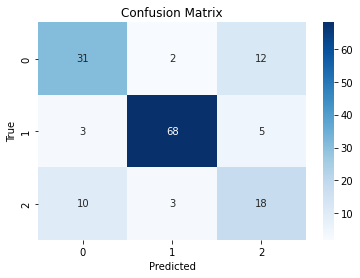

In [79]:
predictions = mnb1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

**Accuracy on test set**

In [80]:
y_pred = mnb1.predict(countVect1.transform(X_test_str))
accuracy = mnb1.score(countVect1.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7697368421052632


In [81]:
from sklearn.model_selection import RandomizedSearchCV

Best parameters: {'fit_prior': True, 'alpha': 1.873817422860383}
Best cross-validation score: 0.7426
Accuracy score: 0.8838


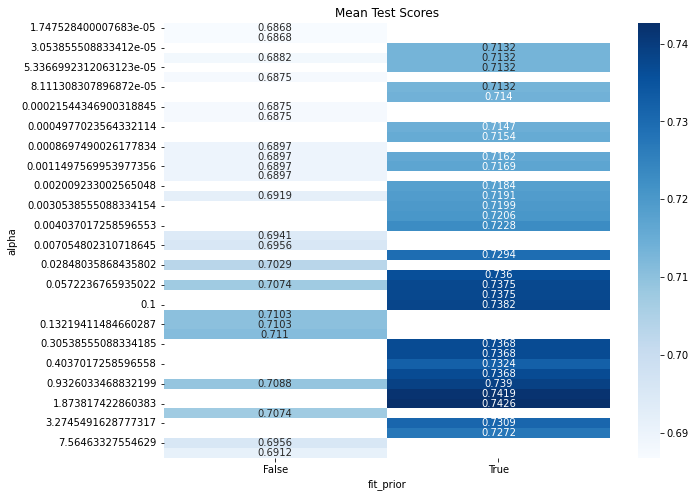

In [82]:
# define the hyperparameters to search over
param_dist = {
    'alpha': np.logspace( -5,1, 100),
    'fit_prior': [True, False],
}

# define the search
searchmnb1 = RandomizedSearchCV(mnb1, param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

searchmnb1.fit(X_train_countVect1, y_train)

# get the best model
best_mnb1 = searchmnb1.best_estimator_
predictions1 = best_mnb1.predict(X_train_countVect1)
accuracy = best_mnb1.score(X_train_countVect1, y_train)

print("Best parameters: {}".format(searchmnb1.best_params_))
print("Best cross-validation score: {:.4f}".format(searchmnb1.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = searchmnb1.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the alpha and fit_prior columns the rows and the mean_test_score column the values
heatmap_df = df.pivot(index='param_alpha', columns='param_fit_prior', values='mean_test_score')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('fit_prior')
plt.ylabel('alpha')
plt.title('Mean Test Scores')
plt.show()



In [83]:

# get the best parameters
best_rf = searchmnb1.best_estimator_
predictions = best_rf.predict(countVect1.transform(X_test_str))
accuracy = best_rf.score(countVect1.transform(X_test_str), y_test)

print("Best parameters: {}".format(searchmnb1.best_params_))
print("Best cross-validation score: {:.4f}".format(searchmnb1.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

Best parameters: {'fit_prior': True, 'alpha': 1.873817422860383}
Best cross-validation score: 0.7426
Accuracy score: 0.7697


**MultinomailNB using TFIDF**

In [84]:
tfidf = TfidfVectorizer(min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train_str)


In [85]:
mnb2 = MultinomialNB()
mnb2.fit(X_train_tfidf, y_train)

MultinomialNB()


Accuracy on validation set: 0.7961

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.80      0.76        45
           1       0.90      0.93      0.92        76
           2       0.61      0.45      0.52        31

    accuracy                           0.80       152
   macro avg       0.74      0.73      0.73       152
weighted avg       0.79      0.80      0.79       152


Confusion Matrix : 
 [[36  4  5]
 [ 1 71  4]
 [13  4 14]]


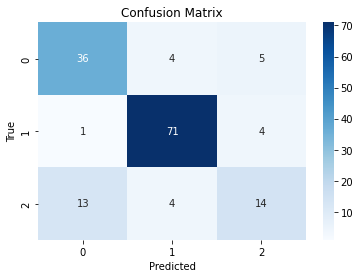

In [86]:
predictions = mnb2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

**On Test set**

In [87]:
y_pred = mnb2.predict(tfidf.transform(X_test_str))
accuracy = mnb2.score(tfidf.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7960526315789473


**MultinomailNB TFIDF RandomizedsearchCV**


Best parameters: {'fit_prior': True, 'alpha': 0.1}
Best cross-validation score: 0.7368
Accuracy score: 0.8404


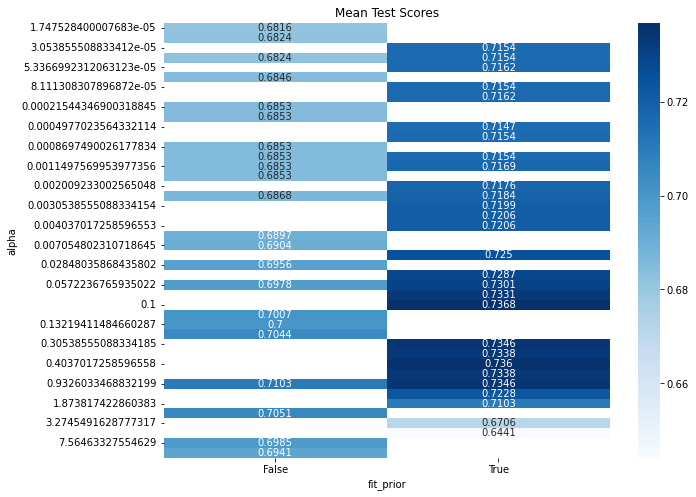

In [88]:
# define the hyperparameters to search over
param_dist = {
    'alpha': np.logspace(-5, 1, 100),
    'fit_prior': [True, False],
}

# define the search
searchmnb2 = RandomizedSearchCV(mnb2, param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

searchmnb2.fit(X_train_tfidf, y_train)

# get the best model
best_mnb2 = searchmnb2.best_estimator_
predictions1 = best_mnb2.predict(X_train_tfidf)
accuracy = best_mnb2.score(X_train_tfidf, y_train)

print("Best parameters: {}".format(searchmnb2.best_params_))
print("Best cross-validation score: {:.4f}".format(searchmnb2.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = searchmnb2.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the alpha and fit_prior columns the rows and the mean_test_score column the values
heatmap_df = df.pivot(index='param_alpha', columns='param_fit_prior', values='mean_test_score')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('fit_prior')
plt.ylabel('alpha')
plt.title('Mean Test Scores')
plt.show()

In [89]:
# get the best parameters
best_rf = searchmnb2.best_estimator_
predictions = best_rf.predict(tfidf.transform(X_test_str))
accuracy = best_rf.score(tfidf.transform(X_test_str), y_test)

print("Best parameters: {}".format(searchmnb2.best_params_))
print("Best cross-validation score: {:.4f}".format(searchmnb2.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

Best parameters: {'fit_prior': True, 'alpha': 0.1}
Best cross-validation score: 0.7368
Accuracy score: 0.7697


**SVM MODEL using countvect**

In [90]:
from sklearn.svm import SVC

In [91]:
svm1 = SVC(kernel='rbf', random_state = 10)
svm1.fit(X_train_countVect1, y_train)

SVC(random_state=10)


Accuracy on validation set: 0.7632

Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.80      0.74        45
           1       0.89      0.86      0.87        76
           2       0.56      0.48      0.52        31

    accuracy                           0.76       152
   macro avg       0.71      0.71      0.71       152
weighted avg       0.76      0.76      0.76       152


Confusion Matrix : 
 [[36  2  7]
 [ 6 65  5]
 [10  6 15]]


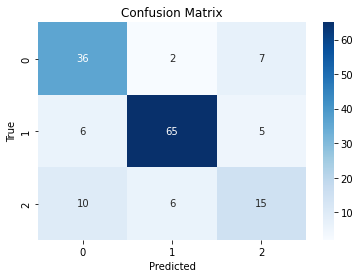

In [92]:
predictions = svm1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

**On Test set**

In [93]:
y_pred = svm1.predict(countVect1.transform(X_test_str))
accuracy = svm1.score(countVect1.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7631578947368421


In [94]:
from scipy.stats import uniform

# Define the hyperparameter ranges
param_dist = {'C': uniform(loc=0, scale=4),
              'gamma': ['scale', 'auto'] + list(uniform(loc=0, scale=1).rvs(10))}

# Create the SVM model
svm1 = SVC(kernel='rbf', random_state=10)

# Perform hyperparameter tuning using RandomizedSearchCV
rand_search = RandomizedSearchCV(svm1, param_distributions=param_dist, cv=5, n_iter=10, random_state=42)
rand_search.fit(X_train_countVect1, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", rand_search.best_params_)

# Get the best model from RandomizedSearchCV
best_model = rand_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(countVect1.transform(X_test_str))

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Best Hyperparameters: {'C': 1.49816047538945, 'gamma': 0.10502315393235595}
Accuracy: 0.7631578947368421


<Axes: xlabel='param_gamma', ylabel='param_C'>

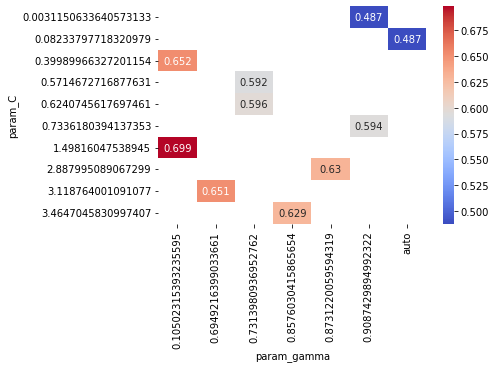

In [95]:
# Convert the results to a DataFrame
results = pd.DataFrame(rand_search.cv_results_)
results = results[['param_C', 'param_gamma', 'mean_test_score']]
results['param_C'] = results['param_C'].astype(float)

# Pivot the table to create a heatmap
heatmap_data = pd.pivot_table(results, values='mean_test_score', index='param_C', columns='param_gamma')

# Create the heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.3g')

 **SVM model using TFIDF**

In [96]:
svm2 = SVC(kernel='rbf', random_state = 10)
svm2.fit(X_train_tfidf, y_train)

SVC(random_state=10)


Accuracy on validation set: 0.7763

Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.76      0.72        45
           1       0.92      0.88      0.90        76
           2       0.57      0.55      0.56        31

    accuracy                           0.78       152
   macro avg       0.73      0.73      0.73       152
weighted avg       0.78      0.78      0.78       152


Confusion Matrix : 
 [[34  3  8]
 [ 4 67  5]
 [11  3 17]]


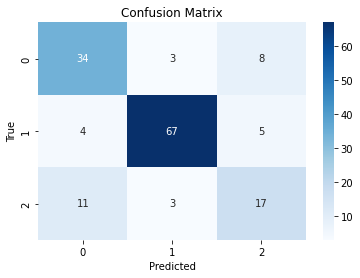

In [97]:
predictions = svm2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

In [98]:
y_pred = svm2.predict(tfidf.transform(X_test_str))
accuracy = svm2.score(tfidf.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7763157894736842


Best Hyperparameters: {'C': 0.7336180394137353, 'gamma': 0.9087429894992322}
Accuracy: 0.7697368421052632


<Axes: xlabel='param_gamma', ylabel='param_C'>

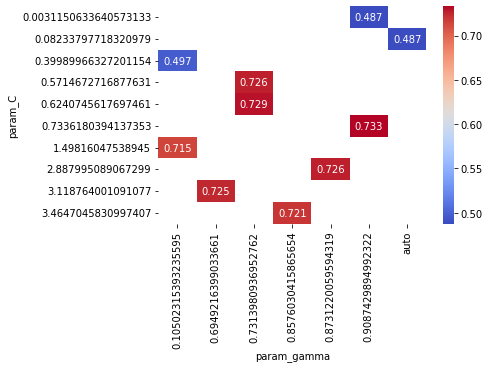

In [99]:
# Perform hyperparameter tuning using RandomizedSearchCV
rand_search = RandomizedSearchCV(svm2, param_distributions=param_dist, cv=5, n_iter=10, random_state=42)
rand_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", rand_search.best_params_)

# Get the best model from RandomizedSearchCV
best_model = rand_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(tfidf.transform(X_test_str))

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

results = pd.DataFrame(rand_search.cv_results_)
results = results[['param_C', 'param_gamma', 'mean_test_score']]
results['param_C'] = results['param_C'].astype(float)

# Pivot the table to create a heatmap
heatmap_data = pd.pivot_table(results, values='mean_test_score', index='param_C', columns='param_gamma')

# Create the heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.3g')

**RandomForestClassifier with Countvec**

In [100]:
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier()

In [101]:
model_1.fit(X_train_countVect1, y_train)

RandomForestClassifier()


Accuracy on validation set: 0.7039

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.58      0.62        45
           1       0.82      0.89      0.86        76
           2       0.43      0.42      0.43        31

    accuracy                           0.70       152
   macro avg       0.64      0.63      0.63       152
weighted avg       0.70      0.70      0.70       152


Confusion Matrix : 
 [[26  8 11]
 [ 2 68  6]
 [11  7 13]]


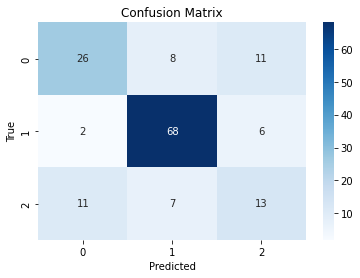

In [102]:
predictions = model_1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

**RF Test set**

In [103]:
y_pred = model_1.predict(countVect1.transform(X_test_str))

In [104]:
accuracy = model_1.score(countVect1.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7039473684210527


**RandomForestClassifier hyperparameter**

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.7110
Accuracy score: 0.9912


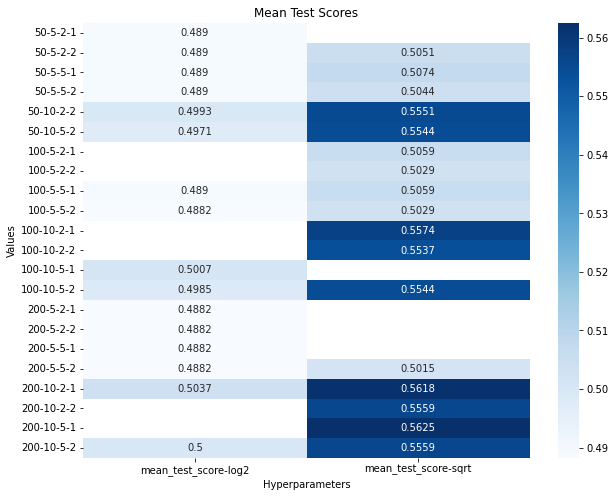

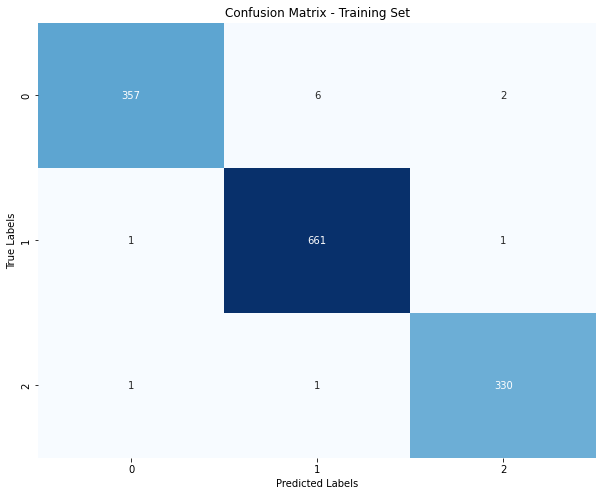

Classification Report - Training Set:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       365
           1       0.99      1.00      0.99       663
           2       0.99      0.99      0.99       332

    accuracy                           0.99      1360
   macro avg       0.99      0.99      0.99      1360
weighted avg       0.99      0.99      0.99      1360



In [105]:
# define the hyperparameters to search over
param_dist = {
    'n_estimators': [50,100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# define the search
search1 = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

search1.fit(X_train_countVect1, y_train)

# get the best model
best_rf = search1.best_estimator_
predictions = best_rf.predict(X_train_countVect1)
accuracy = best_rf.score(X_train_countVect1, y_train)

print("Best parameters: {}".format(search1.best_params_))
print("Best cross-validation score: {:.4f}".format(search1.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = search1.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the hyperparameters the rows and the mean_test_score column the values
heatmap_df = df.pivot_table(index=[f'param_{param}' for param in param_dist.keys()], values='mean_test_score')

# Reshape the DataFrame to have columns for each hyperparameter
heatmap_df = heatmap_df.unstack(level=-1)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('Hyperparameters')
plt.ylabel('Values')
plt.title('Mean Test Scores')
plt.show()

# Create a confusion matrix to evaluate the performance of the modeltrain_cm = confusion_matrix(y_train, predictions)
train_cm = confusion_matrix(y_train, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set the labels
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a classification report to evaluate the performance of the model
train_report = classification_report(y_train, predictions)

# Print the classification report
print('Classification Report - Training Set:\n', train_report)

**RF Hyperparameter on test set**

In [106]:
# get the best parameters
best_rf = search1.best_estimator_
predictions = best_rf.predict(countVect1.transform(X_test_str))
accuracy = best_rf.score(countVect1.transform(X_test_str), y_test)

print("Best parameters: {}".format(search1.best_params_))
print("Best cross-validation score: {:.4f}".format(search1.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.7110
Accuracy score: 0.7632


**RandomForest Classifier using TF-IDF**

In [107]:
model_2 = RandomForestClassifier()
model_2.fit(X_train_tfidf, y_train)

RandomForestClassifier()


Accuracy on validation set: 0.7237

Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.60      0.64        45
           1       0.86      0.87      0.86        76
           2       0.47      0.55      0.51        31

    accuracy                           0.72       152
   macro avg       0.67      0.67      0.67       152
weighted avg       0.73      0.72      0.73       152


Confusion Matrix : 
 [[27  5 13]
 [ 4 66  6]
 [ 8  6 17]]


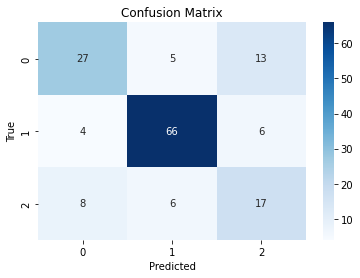

In [108]:
predictions = model_2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

In [109]:
y_pred = model_2.predict(tfidf.transform(X_test_str))
accuracy = model_2.score(tfidf.transform(X_test_str), y_test)

# Print the accuracy score
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.7236842105263158


Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.7074
Accuracy score: 0.9824


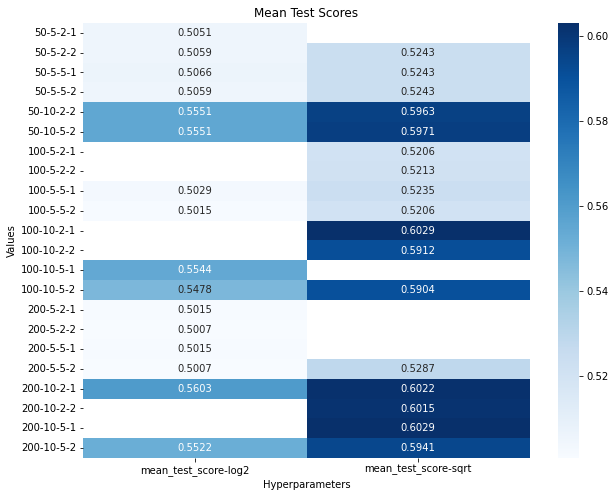

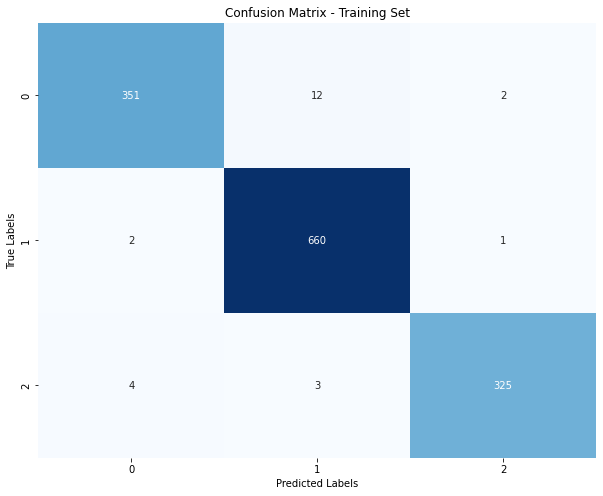

Classification Report - Training Set:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       365
           1       0.98      1.00      0.99       663
           2       0.99      0.98      0.98       332

    accuracy                           0.98      1360
   macro avg       0.98      0.98      0.98      1360
weighted avg       0.98      0.98      0.98      1360



In [110]:
# define the hyperparameters to search over
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# define the search
search2 = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

search2.fit(X_train_tfidf, y_train)

# get the best model
best_rf1 = search2.best_estimator_
predictions = best_rf1.predict(X_train_tfidf)
accuracy = best_rf1.score(X_train_tfidf, y_train)

print("Best parameters: {}".format(search2.best_params_))
print("Best cross-validation score: {:.4f}".format(search2.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = search2.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the hyperparameters the rows and the mean_test_score column the values
heatmap_df = df.pivot_table(index=[f'param_{param}' for param in param_dist.keys()], values='mean_test_score')

# Reshape the DataFrame to have columns for each hyperparameter
heatmap_df = heatmap_df.unstack(level=-1)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('Hyperparameters')
plt.ylabel('Values')
plt.title('Mean Test Scores')
plt.show()

# Create a confusion matrix to evaluate the performance of the modeltrain_cm = confusion_matrix(y_train, predictions)
train_cm = confusion_matrix(y_train, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set the labels
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a classification report to evaluate the performance of the model
train_report = classification_report(y_train, predictions)

# Print the classification report
print('Classification Report - Training Set:\n', train_report)




In [111]:
# get the best model
best_rf = search2.best_estimator_
predictions = best_rf.predict(tfidf.transform(X_test_str))
accuracy = best_rf.score(tfidf.transform(X_test_str), y_test)

print("Best parameters: {}".format(search2.best_params_))
print("Best cross-validation score: {:.4f}".format(search2.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.7074
Accuracy score: 0.7171
